In [ ]:
!wget http://data.csail.mit.edu/places/places365/val_256.tar

--2021-03-05 02:28:29--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/octet-stream]
Saving to: ‘val_256.tar’

val_256.tar         100%[===================>] 500.83M   641KB/s    in 11m 35s 

2021-03-05 02:40:04 (738 KB/s) - ‘val_256.tar’ saved [525158400/525158400]



In [ ]:
!tar -xf val_256.tar

In [ ]:
!cp -a val_256/ images

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, concatenate, Layer, Flatten, Dense
from keras.layers.core import RepeatVector
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import Input, datasets, metrics, optimizers
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from skimage.color import rgb2lab, lab2rgb, grey2rgb, rgb2grey
from skimage.transform import resize
from skimage.io import imsave, imshow, imread
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from google.colab import files
import time
from cv2 import resize, INTER_AREA

In [ ]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)

225214464/225209952 [==============================] - 10s 0us/step


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path,
                 to_fit=True, batch_size=32, dim=(256, 256), shuffle=True, fusion=False, fusion_path='fusion/'):
        """Initialization

        :param list_IDs: list of all 'label' ids to use in the generator
        :param image_path: path to images location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param shuffle: True to shuffle label indexes after every epoch
        :param fusion: True to return X and X_fusion, False returns X
        """
        self.list_IDs = list_IDs
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.fusion = fusion
        self.fusion_path = fusion_path
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images

        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))
        if self.fusion:
          X_fusion = np.empty((self.batch_size, 1000))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_lab_grayscale_image(self.image_path + ID)
            if self.fusion:
              X_fusion[i,] = self._load_fusion(self.fusion_path + ID)

        if self.fusion:
          return [X, X_fusion]
        else:
          return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks

        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim, 2))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_lab_color_image(self.image_path + ID)

        return y

    def _load_lab_grayscale_image(self, image_path):
      img = imread(image_path)
      img = img*(1.0/255)
      img = resize(img, (256, 256))
      if img.shape == (256, 256):
        img = grey2rgb(img)
      img = rgb2lab(img)
      img =(img[:,:,0]).reshape(img[:,:,0].shape+(1,))
      return img

    def _load_fusion(self, image_path):
      with open(image_path, 'rb') as f:
          embed = np.load(f)
          return embed 

    def _load_lab_color_image(self, image_path):
      img = imread(image_path)
      img = img*(1.0/255)
      img = resize(img, (256, 256))
      if img.shape == (256, 256):
        img = grey2rgb(img)
      img = rgb2lab(img)
      img = img[:,:,1:]*(1.0/128)
      return img

In [ ]:
list_of_images = os.listdir("./images")
image_path = "images/"
train_list, val_list = train_test_split(list_of_images[:10000],  test_size = .1, random_state = 1)

In [ ]:
!mkdir fusion

In [ ]:
for image in list_of_images[:10000]:
      img = imread('./images/'+ image)
      img = img*(1.0/255)
      img = grey2rgb(rgb2grey(img))
      img = resize(img, (299, 299))
      img = preprocess_input(img)
      img = img.reshape((1,) + img.shape)
      embed = inception.predict(img)
      with open('./fusion/' + image, 'wb') as f:
          np.save(f, embed)

In [ ]:
!zip -r ./fusion_places.zip ./fusion
from google.colab import files
files.download("fusion_places.zip")

In [ ]:
#Normalize images - divide by 255
#train_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen = DataGenerator(train_list, image_path, fusion = False, batch_size = 100)
val_datagen = DataGenerator(val_list, image_path, fusion = False, batch_size = 100)


In [ ]:
#Vanilla Autoencoder
encoder_input = Input(
    shape=(256, 256, 1,), name="input"
) 

encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)

decoder_output = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       118016

In [ ]:
# Vanilla Autoencoder + inception-resnet-v2

encoder_input = Input(
    shape=(256, 256, 1,), name="input"
) 

embed_input = Input(shape=(1000,))

encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder_output)

fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

decoder_output = Conv2D(128, (3, 3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_204[0][0]                 
______________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.fit(train_datagen, validation_data = val_datagen, epochs=50, callbacks=[es, mc])

Epoch 1/50
90/90 [==============================] - 873s 10s/step - loss: 0.1790 - accuracy: 0.5456 - val_loss: 0.0126 - val_accuracy: 0.6282

Epoch 00001: val_accuracy improved from -inf to 0.62823, saving model to best_model.h5
Epoch 2/50
90/90 [==============================] - 861s 10s/step - loss: 0.0118 - accuracy: 0.6308 - val_loss: 0.0125 - val_accuracy: 0.6271

Epoch 00002: val_accuracy did not improve from 0.62823
Epoch 3/50
90/90 [==============================] - 870s 10s/step - loss: 0.0116 - accuracy: 0.6290 - val_loss: 0.0123 - val_accuracy: 0.6241

Epoch 00003: val_accuracy did not improve from 0.62823
Epoch 4/50
90/90 [==============================] - 858s 10s/step - loss: 0.0116 - accuracy: 0.6265 - val_loss: 0.0121 - val_accuracy: 0.6309

Epoch 00004: val_accuracy improved from 0.62823 to 0.63086, saving model to best_model.h5
Epoch 5/50
90/90 [==============================] - 878s 10s/step - loss: 0.0114 - accuracy: 0.6249 - val_loss: 0.0124 - val_accuracy: 0.6133

In [ ]:
# add logger callback for https://stackoverflow.com/questions/46757852/adding-silent-frame-to-wav-file-using-python
# make asana for project

In [ ]:
!unzip colorize_autoencoder_fusion_10000_50.zip
!unzip colorize_autoencoder_10000_50.zip

Archive:  colorize_autoencoder_fusion_10000_50.zip
   creating: other_files/colorize_autoencoder_fusion_10000_50.model/
   creating: other_files/colorize_autoencoder_fusion_10000_50.model/assets/
   creating: other_files/colorize_autoencoder_fusion_10000_50.model/variables/
  inflating: other_files/colorize_autoencoder_fusion_10000_50.model/variables/variables.index  
  inflating: other_files/colorize_autoencoder_fusion_10000_50.model/variables/variables.data-00000-of-00001  
  inflating: other_files/colorize_autoencoder_fusion_10000_50.model/saved_model.pb  
Archive:  colorize_autoencoder_10000_50.zip
replace other_files/colorize_autoencoder_10000_50.model/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def resize2SquareKeepingAspectRation(img, size, interpolation):
  h, w = img.shape[:2]
  c = None if len(img.shape) < 3 else img.shape[2]
  if h == w: return resize(img, (size, size), interpolation)
  if h > w: dif = h
  else:     dif = w
  x_pos = int((dif - w)/2.)
  y_pos = int((dif - h)/2.)
  if c is None:
    mask = np.zeros((dif, dif), dtype=img.dtype)
    mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
  else:
    mask = np.zeros((dif, dif, c), dtype=img.dtype)
    mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
  return resize(mask, (size, size), interpolation)

(256, 256, 3)


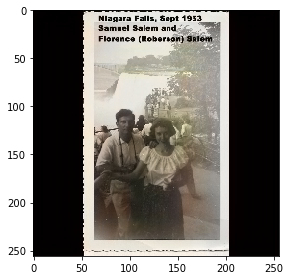

In [ ]:
model = tf.keras.models.load_model(
    'other_files/colorize_autoencoder_fusion_10000_50.model',
    custom_objects=None,
    compile=True)
img1_color=[]
img1 = imread('1953SamandFloSalemB (1)_Original.jpg') #images/Places365_val_00000009.jpg
img1 = img1*(1.0/255)
img1 = resize2SquareKeepingAspectRation(img1 ,256, INTER_AREA)
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

img = imread('1953SamandFloSalemB (1)_Original.jpg')
img = img*(1.0/255)
img = grey2rgb(rgb2grey(img))
img = resize2SquareKeepingAspectRation(img ,299, INTER_AREA)
img = preprocess_input(img)
img = img.reshape((1,) + img.shape)
embed = inception.predict(img)

output1 = model.predict([img1_color, embed])
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
print(result.shape)
#imsave("result.png", lab2rgb(result))
imshow(lab2rgb(result))

(256, 256, 3)


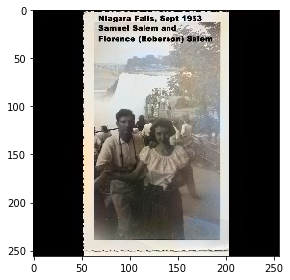

In [ ]:
model = tf.keras.models.load_model(
    'other_files/colorize_autoencoder_10000_50.model',
    custom_objects=None,
    compile=True)
img1_color=[]
img1 = imread('1953SamandFloSalemB (1)_Original.jpg') #images/Places365_val_00000009.jpg
img1 = img1*(1.0/255)
img1 = resize2SquareKeepingAspectRation(img1 ,256, INTER_AREA)
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
print(result.shape)
#imsave("result.png", lab2rgb(result))
imshow(lab2rgb(result))

In [ ]:
model.save('other_files/colorize_autoencoder_10000_50.model')
!zip -r ./other_files/colorize_autoencoder_10000_50.zip ./other_files/colorize_autoencoder_10000_50.model
from google.colab import files
files.download("other_files/colorize_autoencoder_10000_50.zip")

INFO:tensorflow:Assets written to: other_files/colorize_autoencoder_10000_50.model/assets
  adding: other_files/colorize_autoencoder_10000_50.model/ (stored 0%)
  adding: other_files/colorize_autoencoder_10000_50.model/assets/ (stored 0%)
  adding: other_files/colorize_autoencoder_10000_50.model/variables/ (stored 0%)
  adding: other_files/colorize_autoencoder_10000_50.model/variables/variables.index (deflated 73%)
  adding: other_files/colorize_autoencoder_10000_50.model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: other_files/colorize_autoencoder_10000_50.model/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides = 2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

model.fit(train_datagen, validation_data = val_datagen, epochs=10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 512)      

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2, input_shape = (256, 256, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
#model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

model.fit(train_datagen, validation_data = val_datagen, epochs=50)
#model.fit(train_datagen, epochs=1)

#model.fit(X,Y,epochs=5, batch_size=5)

model.save('other_files/colorize_autoencoder_6000_50.model')
!zip -r ./other_files/model_6000_50.zip ./other_files/colorize_autoencoder_6000_50.model
from google.colab import files
files.download("other_files/model_6000_50.zip")

# #Encoder

# model = Sequential()
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

# #Decoder
# #Decoder
# #Note: For the last layer we use tanh instead of Relu. 
# #This is because we are colorizing the image in this layer using 2 filters, A and B.
# #A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
# #as it also has the range between -1 and 1. 
# #Other functions go from 0 to 1.
# model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
# model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
# model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
# model.summary()


# model.fit(X,Y,validation_split=0.1, epochs=5, batch_size=32)

# model.save('other_files/colorize_autoencoder.model')


Streaming output truncated to the last 5000 lines.
168/168 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.6467Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!unzip model_6000_50.zip

Archive:  model_6000_50.zip
   creating: other_files/colorize_autoencoder_6000_50.model/
   creating: other_files/colorize_autoencoder_6000_50.model/variables/
  inflating: other_files/colorize_autoencoder_6000_50.model/variables/variables.data-00000-of-00001  
  inflating: other_files/colorize_autoencoder_6000_50.model/variables/variables.index  
  inflating: other_files/colorize_autoencoder_6000_50.model/saved_model.pb  
   creating: other_files/colorize_autoencoder_6000_50.model/assets/


In [ ]:
# model = tf.keras.models.load_model('other_files/colorize_autoencoder.model')

# # continue fitting
# model.fit(X,Y,validation_split=0.1, epochs=50, batch_size=32)
# model.save('other_files/colorize_autoencoder.model')

In [ ]:
model = tf.keras.models.load_model(
    'other_files/colorize_autoencoder_6000_50.model',
    custom_objects=None,
    compile=True)
img1_color=[]
img1=img_to_array(load_img('images/Places365_val_00000009.jpg')) #/images/Places365_val_00000001.jpg
img1 = resize(img1 ,(256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))
output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
#imsave("result.png", lab2rgb(result))

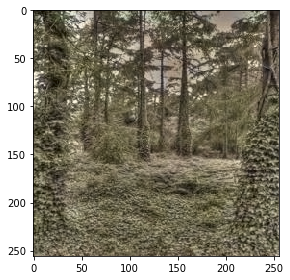

In [ ]:
imshow(lab2rgb(result))

In [ ]:
from google.colab import files
files.download('other_files/colorize_autoencoder_6000_10.model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


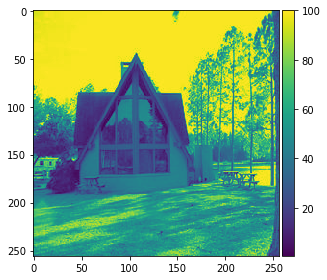

In [ ]:
imshow(train_datagen[0][0][0,:, :, 0])

In [ ]:

# #Convert from RGB to Lab
# """
# by iterating on each image, we convert the RGB to Lab. 
# Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
# The input to the network will be the L channel, so we assign L channel to X vector. 
# And assign A and B to Y.
# """

# X =[]
# Y =[]
# for i in range(10):
#   for img in train[i]:
#     try:
#         lab = rgb2lab(img)
#         X.append(lab[:,:,0]) 
#         Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
#         #so we divide the values by 128 to restrict values to between -1 and 1.
#     except:
#       print('error')
# X = np.array(X)
# Y = np.array(Y)
# X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
# print(X.shape)
# print(Y.shape)
